In [ ]:
import torch
from torch import nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
  
# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"ID of current CUDA device: {torch.cuda.current_device()}")
        
print(f"Name of current CUDA device: {torch.cuda.get_device_name(cuda_id)}")

!nvidia-smi
device = "cpu"

if torch.cuda.is_available():
  device = "cuda"
elif torch.backends.mps.is_available():
  device = "mps"

# device = "cuda"
device

In [5]:
def plot_predictions(
    train_data,
    train_labels,
    test_data,
    test_labels,
    predictions=None,
):

    fig = plt.figure(figsize=(10, 7))
    fig.patch.set_alpha(1.0)

    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        plt.scatter(test_data, predictions, c="r", s=4, label=f"Predictions")

    plt.legend(prop={"size": 14})

In [9]:
class LinearRegressionModelV2(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.linear_layer = nn.Linear(in_features=1, out_features=1)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

# Initialize with random seed
torch.manual_seed(42)

model_1 = LinearRegressionModelV2()

print(list(model_1.parameters()))

print(model_1.state_dict())

# model_1.to(device)
# next(model_1.parameters()).is_cuda
loss_fn = nn.L1Loss()

optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.01)

[Parameter containing:
tensor([[0.7645]], requires_grad=True), Parameter containing:
tensor([0.8300], requires_grad=True)]
OrderedDict([('linear_layer.weight', tensor([[0.7645]])), ('linear_layer.bias', tensor([0.8300]))])


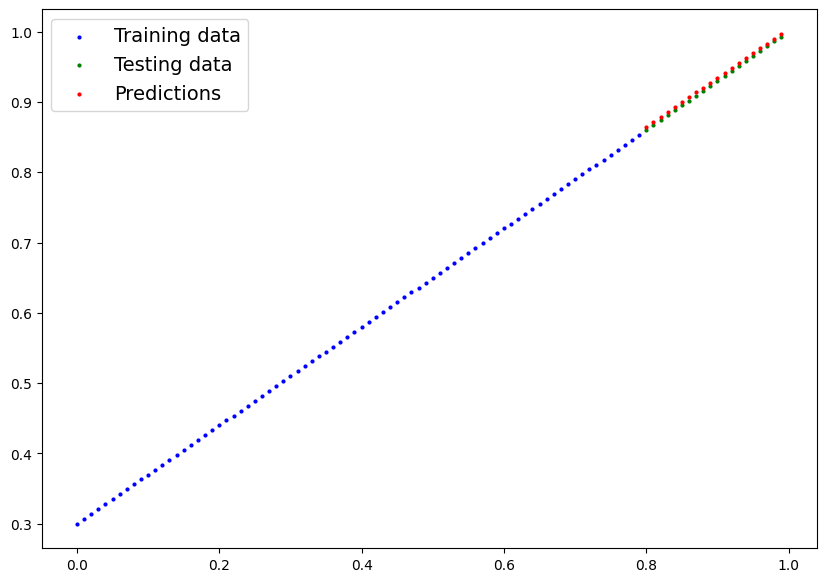

In [17]:
device = "cpu" # Small dataset is faster on CPU

# Create known parameters
weight = 0.7
bias = 0.3

# Create learning model
start = 0
end = 1
step = 0.01
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

# Train/test split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

# Send all data to device
model_1.to(device)
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

# Train
epochs = 10000

losses = []

for epoch in range(epochs):

    # Set model to training mode
    model_1.train()

    # Forward pass
    y_pred = model_1(X_train)

    # Calculate loss
    loss = loss_fn(y_pred, y_train)
     
    loss_corrected = loss if device == "cpu" else loss.cpu()

    losses.append(loss_corrected.detach().numpy())

    # Optimizer zero grad
    # Make optimizer's gradient to be zero so as to not accumulate gradient
    # in each loop
    optimizer.zero_grad()

    # Perform backpropagation
    loss.backward()

    # Perform gradient descent
    optimizer.step()

    model_1.eval()

# Inference after training
with torch.inference_mode():
    predictions = model_1(X_test)

plot_predictions(
    train_data=X_train.cpu(),
    train_labels=y_train.cpu(),
    test_data=X_test.cpu(),
    test_labels=y_test.cpu(),
    predictions=predictions.cpu(),
)